# Generative Adversarial Network - **GAN**

# Uvod
## Šta su GAN?
Generativne adverzalne mreže (GAN) su algoritamske arhitekture koje koriste dve neuronske mreže, suprotstavljajući jednu drugu kako bi generisale nove, lažne, instance podataka koji deluju da su pravi.


> GAN se sastoje od dve komponente:
*   ***Generator*** - generiše nove instance podataka
*   ***Diskriminator*** - pokušava da razlikuje generisane odnosno lažne podatke od stvarnog skupa podataka.

Generativni algoritmi rade suprotno. Umesto da predvide oznaku date određene karakteristike, oni pokušavaju da predvide karakteristike date određenu oznaku.

Dok treniraju, obe komponente počinju od nule, a generator uči da oblikuje slučajnu distribuciju kroz epohe obuke. Tokom treninga, generator progresivno postaje sve bolji u stvaranju realističnih slika, dok diskriminator postaje bolji u njihovom razlikovanju. Proces dostiže ravnotežu kada diskriminator više ne može da razlikuje prave slike od lažnih.

## Kako GAN funkcionišu?
Kao ulaz se koristi nasumični šum koji se prosleđuje generatoru. Generator stvara slike koje se koriste za obuku diskriminatora. Diskriminatoru takođe prosleđujemo i neke karakteristike (eng. *features*), npr. slike životinje, koje želimo da nauči, a diskriminator vraća verovatnoću da je podatak pravi. Sada se izračunava greška koja se vraća diskriminatoru na osnovu koje se menja težina.

Sledi obuka generatora. Koristi se serija izgenerisanih slika koje se ponovo prosleđuju diskriminatoru, međutim, ovog puta se ne prosleđuju karakteristike kao prilikom inicijalne obuke. Generator uči tako što pokušava prevari diskriminator prosleđujući mu *false positive* rezultate.
Diskriminator kao izlaz ponovo vraća verovatnoće. Vrednosti se zatim procenjuju i upoređuju sa onim koje bi trebalo da budu. Izračunava se greška koja se prosleđuje generatoru a shodno tome se menja i težina.

Kroz obuku, generator uči na svojim greškama što znači da generiše podatke koji sve više liče na *feature*.

## Primeri upotrebe GAN.


*   Generisanje slika
*   Modifikacija slika
*   Generisanje govora
*   Starenje lica

# **DCGAN**s - Duboke konvolucione generativne adverzalne mreže
DCGAN-ovi koriste neke od osnovnih principa CNN-a (*convolutional neural networks*) i tako su postali jedna od najčešće korišćenih arhitektura u praksi, zbog svoje brze konvergencije, a takođe i zbog činjenice da se mogu vrlo lako prilagoditi u složenije varijante. Evo nekih od važnijih problema koje DCGAN rešava:


*   Diskriminator je definisan tako da u osnovi rešava zadatak klasifikacije slika pod nadzorom (*supervised image classification*).
*   Filteri koje je GAN naučio mogu se koristiti za crtanje određenih objekata u generisanoj slici
*   Generator sadrži određena svojstva koja mogu naučiti veoma složene semantičke reprezentacije objekata

### Importovanje biblioteka

In [52]:
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import nn, optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset
Skup podataka korišćen u projektu sastoji se od približno 20000 fotografija pasa.

U nastavku se vrši preuzimanje .zip datoteke koja se otpakuje a fotografije se smeštaju u "all-dogs" folder.

In [ ]:
!gdown '1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p' -O 'data.zip'
!unzip data.zip
!unzip all-dogs.zip

Definisanje DogsDataset klase koja omogućava učitavanje podataka sa prosleđene putanje, promenu veličine fotografija i normalizaciju u predefinisanom opsegu - [-1, 1]. Normalizacije se vrši iz razloga što će se u generatoru koristiti *Tanh* aktivacija koja daje izlazni sloj u istom opsegu.

In [53]:
class DogsDataset(Dataset):
    def __init__(self, path, image_size):
        self.X = glob.glob(path + '*')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

    def __getitem__(self,idx):
        img = plt.imread(self.X[idx])
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.X)

Definisanje generatora.

Generator bi po definiciji trebalo da mapira latentni vektor prostora (z) u prostor podataka. Kako se ovde radi o fotografijama potrebno je da kreira RGB fotografiju istih dimenzija kao one u datasetu (64x64x3). Ovo se postiže koristeći serije konvolucijskih transpozicionih slojeva uz 2D batch normalizacijom i ReLu aktivacijom za svaki sloj. Na kraju se koristi Tahn funkcija koja generisane podatke vraća u opseg [-1,1].

In [54]:
class Generator(nn.Module):
    def __init__(self, noise, channels_img, features_g):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=noise,
                out_channels=features_g*16,
                kernel_size = 4,
                stride = 1,
                padding = 0
            ),
            nn.BatchNorm2d(num_features=features_g*16),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*16,
                out_channels=features_g*8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*8),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*8,
                out_channels=features_g*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*4),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*4,
                out_channels=features_g*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*2),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
        )

    def forward(self,x):
        return self.model(x)

Definisanje diskriminatora.

 Kao ulaz se koristi fotografija formata 64x64x3, procesuira se kroz slojeve Conv2d, BatchNorm2d i LeakyReLU i konačno kao izlaz daje verovatnoću da je fotografija prava koristeći Sigmoid aktivacionu funkciju.

In [55]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=channels_img,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d,
                out_channels=features_d*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*2,
                out_channels=features_d*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*4,
                out_channels=features_d*8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0
            ),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.model(x)

### Inicijalizacija težina
Tokom istraživanja se ispostavilo da je ovo jedna od bitnijih stvari za obuku stabilnih GAN-ova. Težine modela moraju biti centrirane na nulu (*mean=0.0*) sa blagim povećanjem standardne devijacije (*stdev=0.02*). Ovo stabilizuje i diskriminator i generator tokom treninga i sprečava da gradijenti modela nestanu ili eksplodiraju.
Za inicijalizaciju se koriste slučajne promenljive (vektor slučajnog šuma).

In [56]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        m.weight.data.normal_(0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Hiperparametri
Postavljanje hiperparametara za obuku modela.

*   **batch_size** - veličina serije koja se koristi tokom obuke modela
*   **image_size** - veličina fotografije koja se koristi u obuci
*   **img_channels** - broj kanala za boje u fotografijama
*   **features_d** - dubina feature mapa u diskriminatoru
*   **features_g** - dubina feature mapa u generatoru
*   **channel_noise** - dužina latentnog vektora
*   **num_epochs** - broj epoha za obuku
*   **lr** - stopa učenja
*   **beta1** - Beta1 parametar za Adam optimizatore



In [57]:
batch_size = 128
image_size = 64
img_channels = 3
features_d = 64
features_g = 64
channel_noise = 128
num_epochs = 3
lr = 0.0002
beta1 = 0.5

Učitavanje dataseta i kreiranje dataloadera.

In [58]:
data = DogsDataset('./all-dogs/', image_size)
dataloader = DataLoader(data, batch_size=batch_size)

Kreiranje diskriminatora i generatora kao i incijalizovanje njihovih težina.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

discrimintaor = Discriminator(img_channels, features_d).to(device)
generator = Generator(channel_noise, img_channels, features_g).to(device)

discrimintaor.apply(weights_init)
generator.apply(weights_init)

Kreiranje optimizera uz preporučene parametre (*learning_rate*=0.0002, *beta1*=0.5) iz zvaničnog istraživanja.

In [60]:
d_optimizer = optim.Adam(discrimintaor.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

Defisanje labele za prave i lažne fotografije koje će se koristiti pri izračunavanju diskriminator i generatora.

In [61]:
real_label = 1
fake_label = 0

Definisanje funckije za izračunavanje gubitaka, koristi se *Binary cross-entropy loss function*.

In [62]:
loss_fn = nn.BCELoss()

## Obuka
Obuka se sastoji iz dva koraka:

**Korak 1 - Trening diskriminatora**

Cilj treninga je da se maksimizira *log(D(x)) + log(1 − D(G(z)))*. Prvo se uzimaju uzorci iz seta sa pravim fotografijama, provlače se kroz model i računa se gubitak (***log(D(x))***). U prolasku unazad se računa gradijent. Sada se uzima set lažnih fotografija iz generatora koje se takođe prosleđuju diskriminatoru nakon čega se ponovo računa gubitak (***log(1 - D(G(z)))***) i gradijent kroz prolaske unazad. Kada se prikupe gradijenti iz oba koraka, vrši se optimizacija diskriminatora.

**Korak 2 - Trening generatora**

Cilj treninga generatora je minimalizovati *log(1 − D(G(z)))*. Ovo se u praksi pokazalo kao neefikasno, pogotovo u početku obuke. Novi cilj je sada maksimiziranje ***log(D(G(z)))***. Ovo se postiže kroz klasifikaciju izlaza generatora iz prvog koraka pomoću diskriminatora, zatim izačunavanje gubitaka generatora, računanje gradijenata u prolasku unazad i, konačno, optimizacija generatora.


Tokom obuke prate se podaci koji će se ispisivati na kraju svake epohe:

*   **d_loss** - gubitak diskriminatora
*   **g_loss** - gubitak generatora
*   **D(x)** - prosečan izlaz diskriminatora
*   **D(z1)** - prosečan izlaz za skup lažnih fotografija pre ažuriranja diskriminatora
*   **D(z2)** - prosečan izlaz za skup lažnih fotografija posle ažuriranja diskriminatora




  0%|          | 0/161 [00:00<?, ?it/s]

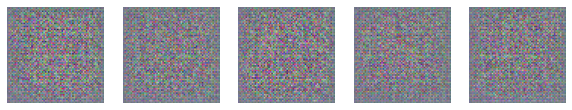

  1%|          | 1/161 [00:16<43:50, 16.44s/it]


d_loss:  2.228865146636963 	g_loss:  7.682470321655273 
D(x):  0.6215271949768066 	D(G(z1)):  0.7594703435897827 	D(G(z2)):  0.0007025339873507619


  0%|          | 0/161 [00:00<?, ?it/s]

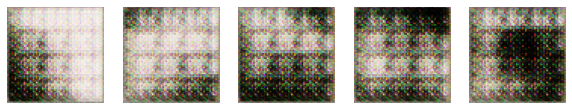

  1%|          | 1/161 [00:16<44:32, 16.70s/it]


d_loss:  0.9135246872901917 	g_loss:  2.8131470680236816 
D(x):  0.7487000823020935 	D(G(z1)):  0.3474172353744507 	D(G(z2)):  0.09819567948579788


  0%|          | 0/161 [00:00<?, ?it/s]

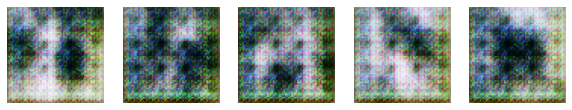

  1%|          | 1/161 [00:16<42:59, 16.12s/it]


d_loss:  0.5358842015266418 	g_loss:  4.20443868637085 
D(x):  0.8275667428970337 	D(G(z1)):  0.24105152487754822 	D(G(z2)):  0.022884247824549675


100%|██████████| 161/161 [43:15<00:00, 16.12s/it]


In [63]:
d_losses = []
g_losses = []
iters = 0

for epoch in range(num_epochs):
  for batch_i, data in enumerate(tqdm(dataloader, total=int(len(dataloader)))):
    # Trening Diskriminatora
    discrimintaor.zero_grad()

    batch_size = data.shape[0]
    data = data.to(device)

    label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)

    output = discrimintaor(data).reshape(-1)
    d_loss_real = loss_fn(output, label)
    d_loss_real.backward()
    d_x = output.mean().item()

    noise = torch.randn(batch_size, channel_noise, 1, 1).to(device)
    fake = generator(noise).to(device)
    label.fill_(fake_label)

    output = discrimintaor(fake.detach()).reshape(-1)
    
    d_loss_fake = loss_fn(output, label)
    d_loss_fake.backward()
    d_g_z1 = output.mean().item()

    d_loss_total = d_loss_real + d_loss_fake

    d_optimizer.step()

    # Trening Generatora
    generator.zero_grad()
    label.fill_(real_label)

    output = discrimintaor(fake).reshape(-1)
    g_loss = loss_fn(output, label)
    g_loss.backward()
    d_g_z2 = output.mean().item()
    g_optimizer.step()

    d_losses.append(d_loss_total.item())
    g_losses.append(g_loss.item())

    if batch_i == 0:
      plt.figure(figsize=(10,7))
      for i , img in enumerate(fake[:5], 1):
        img = img.cpu().detach().numpy().transpose((1, 2, 0))
        img = 0.5 * img + 0.5
        img = np.clip(img, 0, 1)
        plt.axis('off')
        plt.subplot(1, 5, i)
        plt.imshow(img)
      plt.axis('off')
      plt.show()

      print('\nd_loss: ', d_loss_total.item(), '\tg_loss: ', g_loss.item(),
            '\nD(x): ', d_x, '\tD(G(z1)): ', d_g_z1, '\tD(G(z2)): ', d_g_z2
      )

    iters += 1

Prikaz dijagrama gubitaka po interacijama.

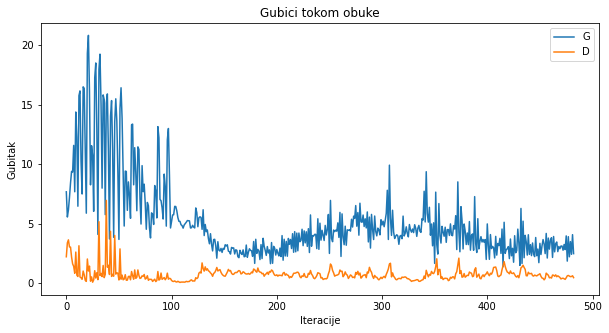

In [64]:
plt.figure(figsize=(10,5))
plt.title("Gubici tokom obuke")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Iteracije")
plt.ylabel("Gubitak")
plt.legend()
plt.show()

# Literatura
[1] [UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS, Alec Radford & Luke Metz, Soumith Chintala](https://arxiv.org/pdf/1511.06434.pdf)


[2] [Generative Adversarial Nets, Ian J. Goodfellow](https://arxiv.org/pdf/1406.2661.pdf)


[3] [Conditional Generative Adversarial Nets, Mehdi Mirza](https://arxiv.org/pdf/1411.1784.pdf)


[3] [How to train your touchy GANs - Things that seem to work.](https://www.kaggle.com/c/generative-dog-images/discussion/102155#latest-599429)


[4] [Weight Initialization Techniques in Neural Networks](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)

[5] [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)